<a href="https://colab.research.google.com/github/fathanzys/Data/blob/main/uas_DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Install pycountry_convert untuk konversi negara ke benua
!pip install pycountry-convert --quiet

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import pycountry_convert as pc
import warnings
warnings.filterwarnings("ignore")

#**Data Collection**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/DM/salaries.csv")

print("Jumlah baris & kolom:", df.shape)
df.head()

Jumlah baris & kolom: (141566, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,EN,FT,Data Quality Analyst,60000,GBP,75949,GB,0,GB,M
1,2025,EN,FT,Data Quality Analyst,48000,GBP,60759,GB,0,GB,M
2,2025,SE,FT,Applied Scientist,266000,USD,266000,US,0,US,M
3,2025,SE,FT,Applied Scientist,204000,USD,204000,US,0,US,M
4,2025,SE,FT,Data Scientist,291000,USD,291000,US,0,US,M


#**Pre Processing**

In [45]:
# Hapus baris duplikat (jika ada)
df.drop_duplicates(inplace=True)

# Cek missing value
print("Missing values per kolom:\n", df.isnull().sum())

# Hapus kolom 'salary' karena kita akan fokus ke salary_in_usd sebagai target
df.drop(columns=['salary'], inplace=True)

Missing values per kolom:
 work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


#**EDA**

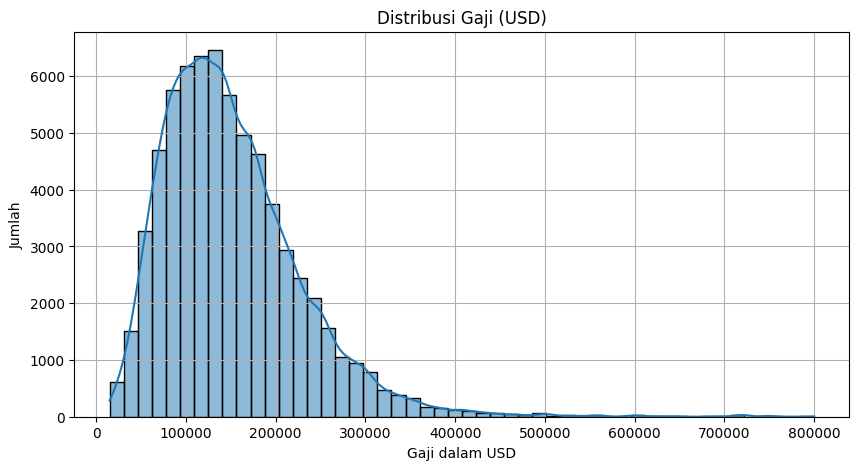

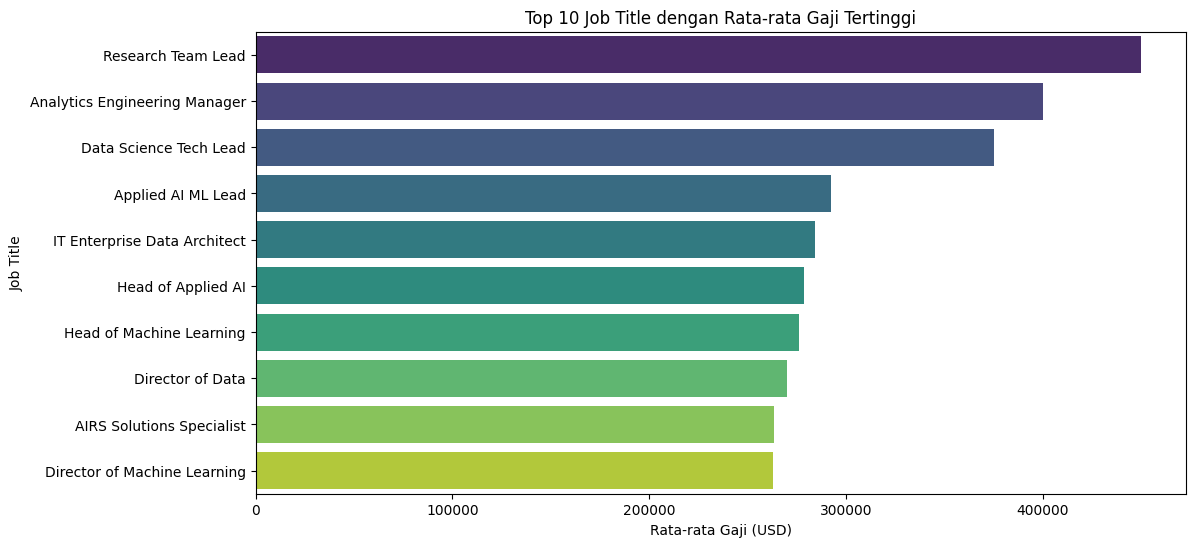

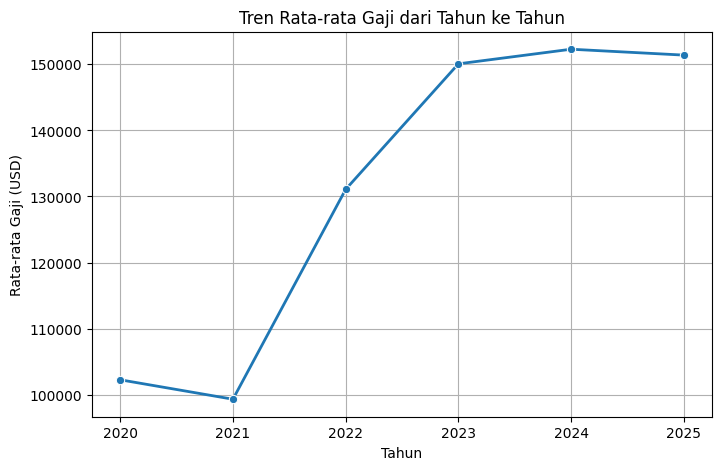

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribusi Gaji (USD)
plt.figure(figsize=(10, 5))
sns.histplot(df['salary_in_usd'], bins=50, kde=True)
plt.title('Distribusi Gaji (USD)')
plt.xlabel('Gaji dalam USD')
plt.ylabel('Jumlah')
plt.grid(True)
plt.show()

# Top 10 Job Title berdasarkan Rata-rata Gaji
plt.figure(figsize=(12, 6))
top_jobs = df.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_jobs.values, y=top_jobs.index, palette='viridis')
plt.title('Top 10 Job Title dengan Rata-rata Gaji Tertinggi')
plt.xlabel('Rata-rata Gaji (USD)')
plt.ylabel('Job Title')
plt.show()

# Perkembangan Gaji dari Tahun ke Tahun
plt.figure(figsize=(8, 5))
avg_salary_by_year = df.groupby('work_year')['salary_in_usd'].mean()
sns.lineplot(x=avg_salary_by_year.index, y=avg_salary_by_year.values, marker='o', linewidth=2)
plt.title('Tren Rata-rata Gaji dari Tahun ke Tahun')
plt.xlabel('Tahun')
plt.ylabel('Rata-rata Gaji (USD)')
plt.grid(True)
plt.show()

#**Feature Engineering**

In [48]:
import pycountry_convert as pc

# Fungsi untuk mengubah country code ke nama benua
def country_to_continent(country_code):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_code)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = {
            "AF": "Africa",
            "NA": "North America",
            "OC": "Oceania",
            "AN": "Antarctica",
            "AS": "Asia",
            "EU": "Europe",
            "SA": "South America"
        }
        return continent_name.get(continent_code, "Other")
    except:
        return "Other"

# Terapkan ke employee_residence & company_location
df['employee_continent'] = df['employee_residence'].apply(country_to_continent)
df['company_continent'] = df['company_location'].apply(country_to_continent)

# Buat kolom level gaji
df['salary_level'] = pd.qcut(df['salary_in_usd'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Cek hasilnya
df[['salary_in_usd', 'salary_level', 'company_continent']].head()

,salary_in_usd,salary_level,company_continent
0,75949,Low,Other
1,60759,Low,Other
2,266000,Very High,Other
3,204000,Very High,Other
4,291000,Very High,Other


#**Encode & Split**

In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Salin data
df_model = df.copy()

# DROP kolom yang tidak dibutuhkan / redundant
drop_cols = []
if 'salary_currency' in df_model.columns:
    drop_cols.append('salary_currency')
if 'salary' in df_model.columns:  # jaga-jaga
    drop_cols.append('salary')
if drop_cols:
    df_model.drop(columns=drop_cols, inplace=True)

# Pastikan kolom feature engineering sudah ada (jika belum jalankan step sebelumnya)
# categorical_features:
categorical_features = [
    'experience_level', 'employment_type', 'job_title',
    'employee_residence', 'company_location', 'company_size',
    'employee_continent', 'company_continent', 'salary_level'
]

# Label encode semua kolom kategorikal
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

# Definisi fitur dan target
X = df_model.drop(['salary_in_usd'], axis=1)
y = df_model['salary_in_usd']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("Feature dtypes:\n", X_train.dtypes)

X_train: (54310, 11) | X_test: (13578, 11)
Feature dtypes:
 work_year             int64
experience_level      int64
employment_type       int64
job_title             int64
employee_residence    int64
remote_ratio          int64
company_location      int64
company_size          int64
employee_continent    int64
company_continent     int64
salary_level          int64
dtype: object


#**Model Training**

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Inisialisasi model
lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)

# Training model
lr_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# Prediksi
lr_preds = lr_model.predict(X_test)
dt_preds = dt_model.predict(X_test)

# Fungsi Evaluasi
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Evaluation:")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.4f}")
    print("="*30)

# Evaluasi Model
evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("Decision Tree", y_test, dt_preds)

Linear Regression Evaluation:
MAE  : 51211.83
RMSE : 64394.75
R²   : 0.3149
Decision Tree Evaluation:
MAE  : 21256.74
RMSE : 37814.55
R²   : 0.7637


#**Visualisasi**

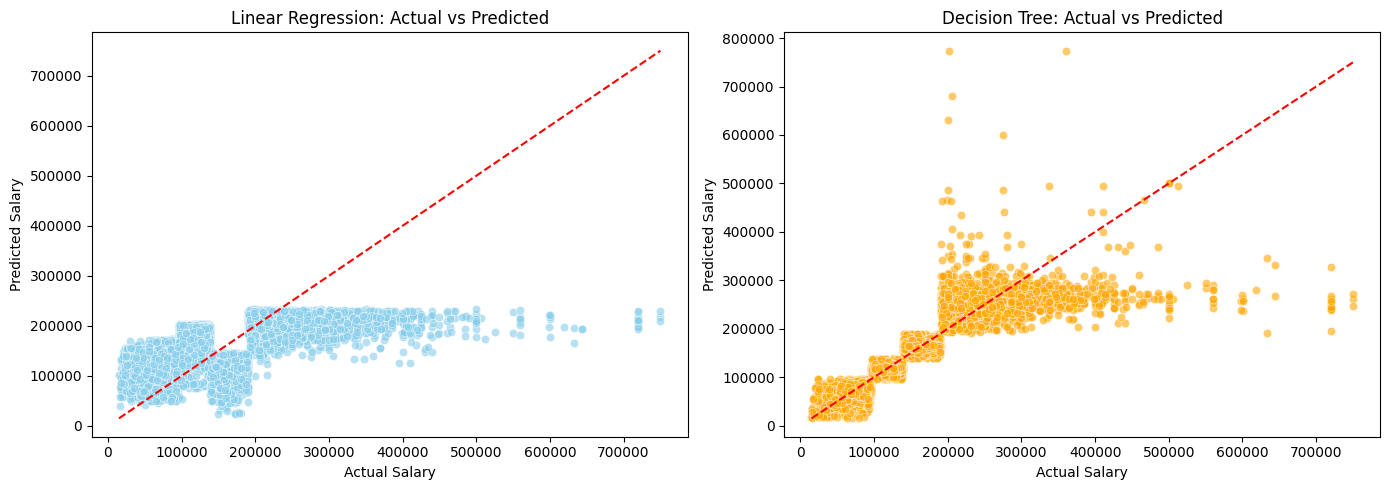

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi: Actual vs Predicted
plt.figure(figsize=(14, 5))

# Linear Regression
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.6, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Linear Regression: Actual vs Predicted')

# Decision Tree
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=dt_preds, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Decision Tree: Actual vs Predicted')

plt.tight_layout()
plt.show()

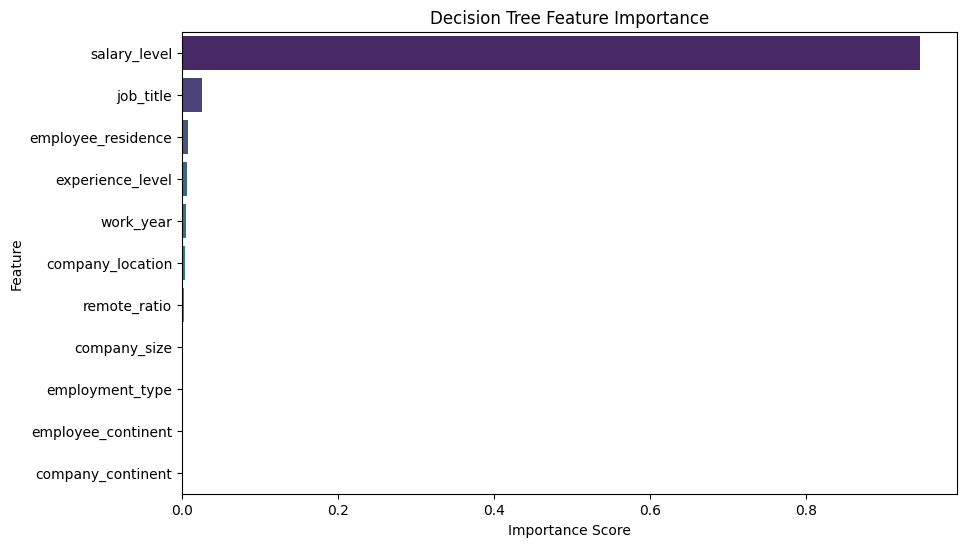

In [62]:
# Feature Importance dari Decision Tree
importances = dt_model.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')
plt.title("Decision Tree Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [65]:
import pandas as pd

def predict_salary_interactive(model, label_encoders_dict, input_dict):
    # Convert input to DataFrame
    input_df = pd.DataFrame([input_dict])

    # Identify categorical features and apply label encoding
    categorical_features_in_input = [col for col in input_df.columns if col in label_encoders_dict]

    for col in categorical_features_in_input:
        try:
            # Ensure the input value is in a list format for the encoder's transform method
            input_df[col] = label_encoders_dict[col].transform(input_df[col])
        except ValueError as e:
            print(f"Error encoding column '{col}': {e}")
            print(f"Ensure the input value for '{col}' is one of the categories seen during training.")
            return None # Or handle the error appropriately

    # Predict salary
    predicted_salary = model.predict(input_df)

    return predicted_salary[0]

In [67]:
# Contoh input
sample_input = {
    'work_year': 2023,
    'experience_level': 'SE',    # MI, SE, EN, EX
    'employment_type': 'FT',     # FT, PT, CT, FL
    'job_title': 'Data Scientist',
    'employee_residence': 'US',
    'remote_ratio': 100,         # 0, 50, 100
    'company_location': 'US',
    'company_size': 'M',          # S, M, L
    'employee_continent': 'North America', # Added based on feature engineering
    'company_continent': 'North America', # Added based on feature engineering
    'salary_level': 'High' # Added based on feature engineering
}

# Use the best performing model (based on previous evaluation, e.g., dt_model or xgb_model)
# For this example, using dt_model as it was evaluated earlier
best_model = dt_model

# Pass the dictionary of label encoders to the function
predicted = predict_salary_interactive(best_model, label_encoders, sample_input)

if predicted is not None:
    print(f"💸 Predicted Salary ({'Decision Tree' if best_model == dt_model else 'Linear Regression' if best_model == lr_model else 'Model'}): ${predicted:,.2f}")

Error encoding column 'employee_continent': y contains previously unseen labels: 'North America'
Ensure the input value for 'employee_continent' is one of the categories seen during training.


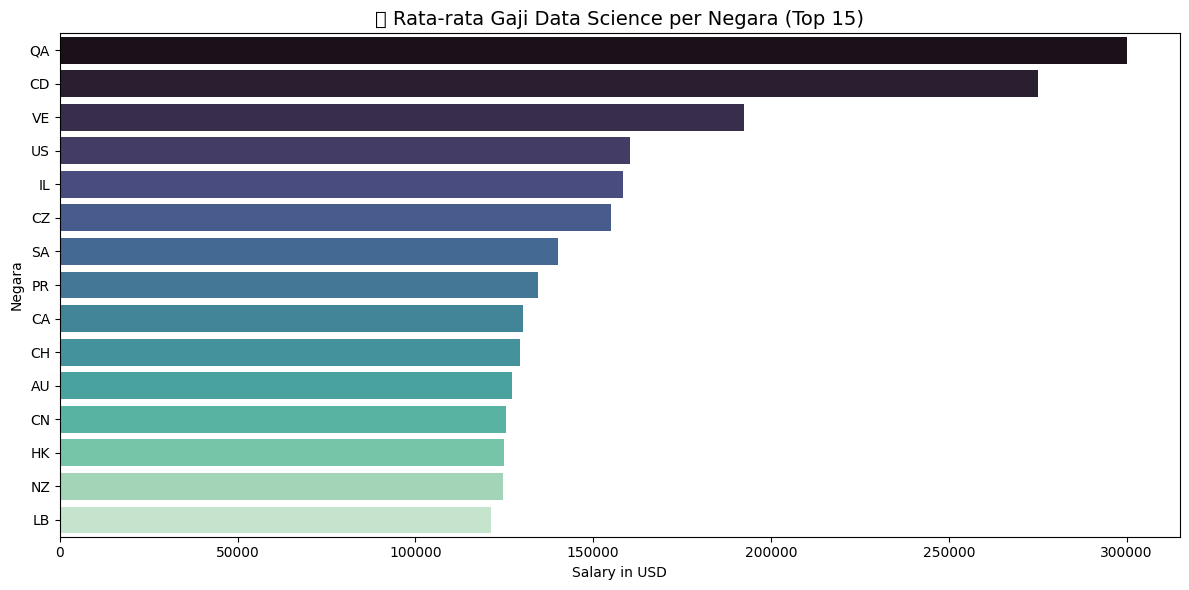

In [68]:
avg_salary_country = df.groupby('employee_residence')['salary_in_usd'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_salary_country.values, y=avg_salary_country.index, palette='mako')
plt.title('💰 Rata-rata Gaji Data Science per Negara (Top 15)', fontsize=14)
plt.xlabel('Salary in USD')
plt.ylabel('Negara')
plt.tight_layout()
plt.show()

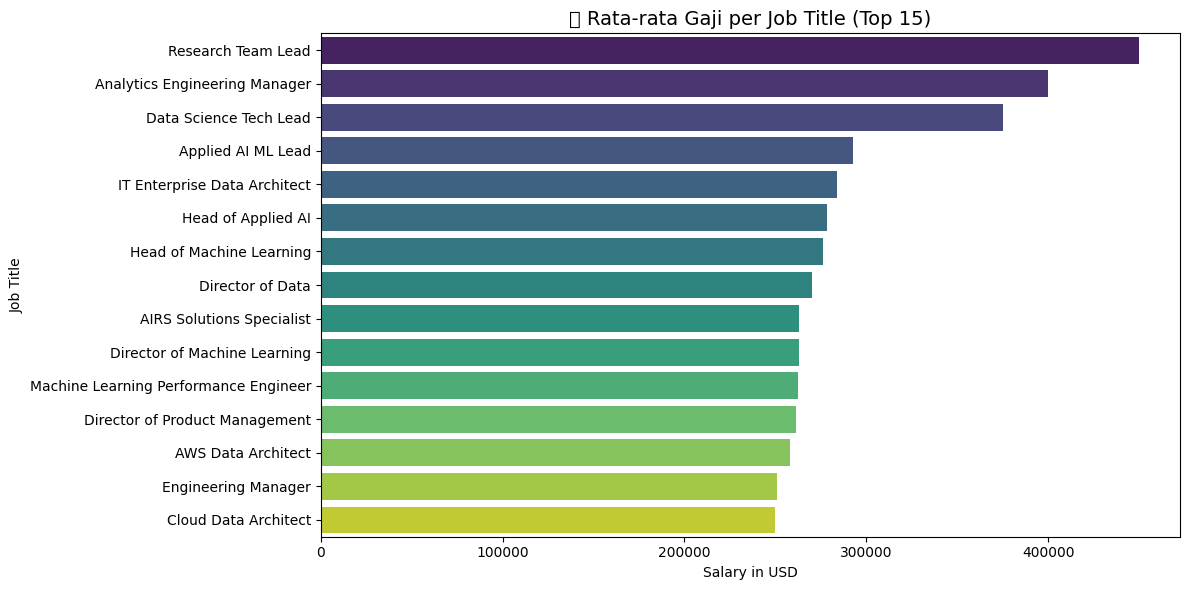

In [69]:
avg_salary_job = df.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_salary_job.values, y=avg_salary_job.index, palette='viridis')
plt.title('🧠 Rata-rata Gaji per Job Title (Top 15)', fontsize=14)
plt.xlabel('Salary in USD')
plt.ylabel('Job Title')
plt.tight_layout()
plt.show()

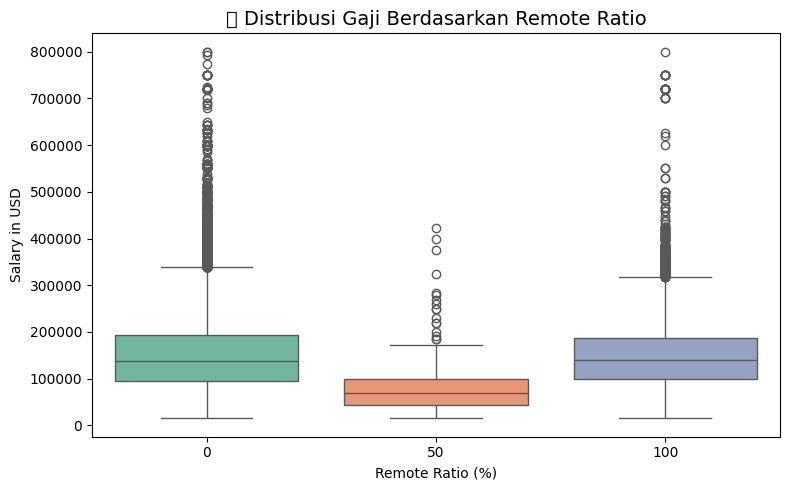

In [70]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='remote_ratio', y='salary_in_usd', palette='Set2')
plt.title('📦 Distribusi Gaji Berdasarkan Remote Ratio', fontsize=14)
plt.xlabel('Remote Ratio (%)')
plt.ylabel('Salary in USD')
plt.tight_layout()
plt.show()


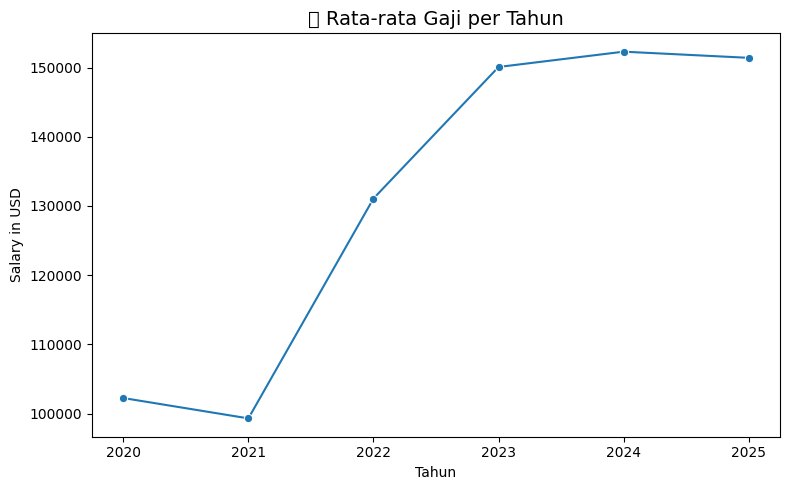

In [71]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df, x='work_year', y='salary_in_usd', estimator='mean', ci=None, marker='o')
plt.title('📈 Rata-rata Gaji per Tahun', fontsize=14)
plt.xlabel('Tahun')
plt.ylabel('Salary in USD')
plt.tight_layout()
plt.show()